In [1]:
import requests
import os
import urllib

import pandas as pd
import pygrib

from datetime import datetime

# Configuration
cwd = os.getcwd()

MESONET_DATA_URL = "http://xmountwashington.appspot.com/mmNew.php?callback=null"
MESONET_CSV_PATH = os.path.join(cwd, "data/mesonet/MesonetData2019.csv")


TARGET_DEM_URL = "https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/13/ArcGrid/USGS_NED_13_n45w072_ArcGrid.zip"
TARGET_DEM_FILE_ZIP = os.path.join(cwd, "tmp/dem.zip")
TARGET_DEM_FILE_UNZIP = os.path.join(cwd, "data/dem")
TARGET_DEM_DATA_FILE = os.path.join(TARGET_DEM_FILE_UNZIP, "grdn45w072_13", "w001001.adf")

RTMA_URL_PREFIX = "ftp://ftp.ncep.noaa.gov/pub/data/nccf/com/rtma/prod/"
TARGET_RTMA_DIR = os.path.join(cwd, "data/RTMA")

TARGET_SHAPEFILE_OUTPUT_DIR = os.path.join(cwd, "results/shapes")
DEFAULT_SHAPEFILE_OUTPUT_FNAME = os.path.join(TARGET_SHAPEFILE_OUTPUT_DIR, "results.shp")

# A ratio of number-of-datapoints-in-input-dem to number-of-datapoints-in-output
# This value must be less than 1.  1 would achieve the highest possible resolution but result in the longest compute times
OUTPUT_RESOLUTION = 1/10

In [5]:
def get_rtma_by_date(target_datetime, target_path=TARGET_RTMA_DIR):
    '''
    Retrieve an rtma grib file based on the target datetime.
    
    Parameters
    ----------
    target_datetime: datetime
        The datetime to pull
        
    Returns
    ----------
    local_path: str
        Local path where the rtma resides.  Returns None if file cannot be found.
    '''
    FILE_PATTERN = "rtma2p5_ru.%Y%m%d/rtma2p5_ru.t%H%Mz.2dvaranl_ndfd.grb2"
    
    source_file = target_datetime.strftime(FILE_PATTERN)
    source_url = RTMA_URL_PREFIX + source_file
    download_file(source_url, os.path.join(target_path, source_file))
    

def download_file(url, target, clobber=False):
    '''
    Download the specified file to the target, optionally clobbering the existing file.
    Works with both https and ftp protocols.  Creates target directory if it doesn't
    already exist.
    '''
    _make_dirs_if_no_exists(target)
    print("Downloading file %s" % url)
    if os.path.exists(target) and not clobber:
        print("Path %s already exists; using previously downloaded file." % target)
        return False
    return urllib.request.urlretrieve(url, target)  


def _make_dirs_if_no_exists(dirname):
    '''
    Attempt to make a directory if it doesn't exist already.
    '''
    if not os.path.exists(os.path.dirname(dirname)):
        print("Path %s does not exist.  Attempting to make it now." % os.path.dirname(dirname))
        os.makedirs(os.path.dirname(dirname))

In [14]:
# mesonet csv to dataframe
df = pd.read_csv(MESONET_CSV_PATH, parse_dates=True, infer_datetime_format=True)

In [8]:
import datetime

RTMC_URL = "ftp://ftp.ncdc.noaa.gov/pub/has/HAS011368321/"
RTMC_FILE_PATTERN = "9950_NDGD_LTM_%Y%m%d.tar"
START_DATE = datetime.datetime(2017, 1, 1)
END_DATE = datetime.datetime(2018, 12, 31)
INTERVAL = datetime.timedelta(days=1)

current_date = START_DATE
while current_date < END_DATE:
    current_file = current_date.strftime(RTMC_FILE_PATTERN)
    current_url = RTMC_URL + current_file
    target_path = os.path.join(TARGET_RTMA_DIR, current_file)
    download_file(current_url, target_path)
    current_date += INTERVAL

Path /external/mesonet-interpolation/temperature/data/RTMA/9950_NDGD_LTM_20170101.tar already exists; using previously downloaded file.
Path /external/mesonet-interpolation/temperature/data/RTMA/9950_NDGD_LTM_20170102.tar already exists; using previously downloaded file.
Path /external/mesonet-interpolation/temperature/data/RTMA/9950_NDGD_LTM_20170103.tar already exists; using previously downloaded file.
Path /external/mesonet-interpolation/temperature/data/RTMA/9950_NDGD_LTM_20170104.tar already exists; using previously downloaded file.
Path /external/mesonet-interpolation/temperature/data/RTMA/9950_NDGD_LTM_20170105.tar already exists; using previously downloaded file.
Path /external/mesonet-interpolation/temperature/data/RTMA/9950_NDGD_LTM_20170106.tar already exists; using previously downloaded file.
Path /external/mesonet-interpolation/temperature/data/RTMA/9950_NDGD_LTM_20170107.tar already exists; using previously downloaded file.
Path /external/mesonet-interpolation/temperature

Path /external/mesonet-interpolation/temperature/data/RTMA/9950_NDGD_LTM_20180316.tar already exists; using previously downloaded file.
Path /external/mesonet-interpolation/temperature/data/RTMA/9950_NDGD_LTM_20180317.tar already exists; using previously downloaded file.
Path /external/mesonet-interpolation/temperature/data/RTMA/9950_NDGD_LTM_20180318.tar already exists; using previously downloaded file.
Path /external/mesonet-interpolation/temperature/data/RTMA/9950_NDGD_LTM_20180319.tar already exists; using previously downloaded file.
Path /external/mesonet-interpolation/temperature/data/RTMA/9950_NDGD_LTM_20180320.tar already exists; using previously downloaded file.
Path /external/mesonet-interpolation/temperature/data/RTMA/9950_NDGD_LTM_20180321.tar already exists; using previously downloaded file.
Path /external/mesonet-interpolation/temperature/data/RTMA/9950_NDGD_LTM_20180322.tar already exists; using previously downloaded file.
Path /external/mesonet-interpolation/temperature

URLError: <urlopen error ftp error: URLError("ftp error: error_perm('550 9950_NDGD_LTM_20181205.tar: No such file or directory')")>

In [42]:
# real-time mesoscale analysis ingest and comparison
#print(df.strftime("%Y"))
#print(type(df["date"].strftime("%Y")))
#print(df)
#print(dir(df['date']))
#print(df['date'].to_timestamp())
#print(df['date'].dt.date)
for idx, r in df.iterrows():
    try:
        get_rtma_by_date(pd.to_datetime(r['date']))
    except urllib.error.URLError:
        print("Couldn't download for %s", r['date'])

Couldn't download for %s 2019-01-01 00:00:00
Couldn't download for %s 2019-01-01 00:01:00
Couldn't download for %s 2019-01-01 00:02:00
Couldn't download for %s 2019-01-01 00:03:00
Couldn't download for %s 2019-01-01 00:04:00
Couldn't download for %s 2019-01-01 00:05:00
Couldn't download for %s 2019-01-01 00:06:00
Couldn't download for %s 2019-01-01 00:07:00
Couldn't download for %s 2019-01-01 00:08:00
Couldn't download for %s 2019-01-01 00:09:00
Couldn't download for %s 2019-01-01 00:10:00
Couldn't download for %s 2019-01-01 00:11:00
Couldn't download for %s 2019-01-01 00:12:00
Couldn't download for %s 2019-01-01 00:13:00
Couldn't download for %s 2019-01-01 00:14:00
Couldn't download for %s 2019-01-01 00:15:00
Couldn't download for %s 2019-01-01 00:16:00
Couldn't download for %s 2019-01-01 00:17:00
Couldn't download for %s 2019-01-01 00:18:00


KeyboardInterrupt: 

In [40]:
mesonet_df = get_mesonet_archive(MESONET_ARCHIVE_PATH)

Examining file /tmp/tmpnfr1qnos/LTMA98_KWBR_201710080000
1:2 metre temperature:K (instant):lambert:heightAboveGround:level 2 m:fcst time 0 hrs:from 201710080000
2:2 metre temperature:K (instant):lambert:heightAboveGround:level 2 m:fcst time 0 hrs:from 201710080000


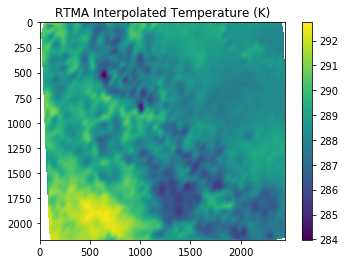

AR16: 289.228942
AR23: 289.383615
AR33: 289.938955
AR40: 290.292975
AR43: 290.191618
AR53: 289.909186
ATTI: 287.892206
BRWD: 289.979154
CANN: 286.888751
CRAN: 287.077108
HICR: 288.830306
JACK: 287.853543
NCON: 287.928742
TUCK: 288.709685
WILD: 287.938443
Examining file /tmp/tmpnfr1qnos/LTMA98_KWBR_201710080100
1:2 metre temperature:K (instant):lambert:heightAboveGround:level 2 m:fcst time 0 hrs:from 201710080100
2:2 metre temperature:K (instant):lambert:heightAboveGround:level 2 m:fcst time 0 hrs:from 201710080100


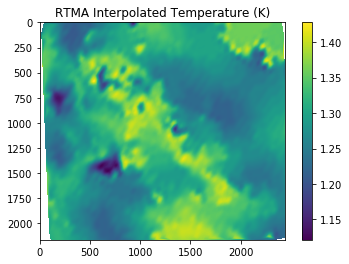

AR16: 1.356924
AR23: 1.357779
AR33: 1.359864
AR40: 1.365296
AR43: 1.361452
AR53: 1.357480
ATTI: 1.319820
BRWD: 1.329744
CANN: 1.392351
CRAN: 1.299732
HICR: 1.326528
JACK: 1.317072
NCON: 1.302921
TUCK: 1.350711
WILD: 1.359193
Examining file /tmp/tmpnfr1qnos/LTMA98_KWBR_201710080200
1:2 metre temperature:K (instant):lambert:heightAboveGround:level 2 m:fcst time 0 hrs:from 201710080200
2:2 metre temperature:K (instant):lambert:heightAboveGround:level 2 m:fcst time 0 hrs:from 201710080200


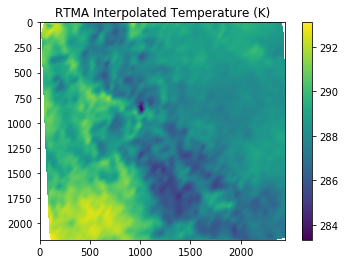

AR16: 288.655081
AR23: 288.129476
AR33: 288.122920
AR40: 288.407402
AR43: 288.100257
AR53: 287.709661
ATTI: 288.302519
BRWD: 290.137710
CANN: 288.083533
CRAN: 288.254071
HICR: 287.935970
JACK: 288.281651
NCON: 288.828039
TUCK: 287.143568
WILD: 287.457459
Examining file /tmp/tmpnfr1qnos/LTMA98_KWBR_201710080300
1:2 metre temperature:K (instant):lambert:heightAboveGround:level 2 m:fcst time 0 hrs:from 201710080300
2:2 metre temperature:K (instant):lambert:heightAboveGround:level 2 m:fcst time 0 hrs:from 201710080300


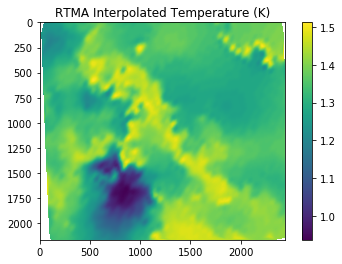

AR16: 1.260064
AR23: 1.252774
AR33: 1.254422
AR40: 1.283422
AR43: 1.258124
AR53: 1.243771
ATTI: 1.346038
BRWD: 1.283320
CANN: 1.272705
CRAN: 1.400174
HICR: 1.291315
JACK: 1.393053
NCON: 1.371213
TUCK: 1.255276
WILD: 1.276820
Examining file /tmp/tmpnfr1qnos/LTMA98_KWBR_201710080400
1:2 metre temperature:K (instant):lambert:heightAboveGround:level 2 m:fcst time 0 hrs:from 201710080400
2:2 metre temperature:K (instant):lambert:heightAboveGround:level 2 m:fcst time 0 hrs:from 201710080400


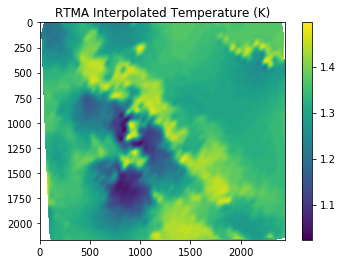

AR16: 1.041502
AR23: 1.046728
AR33: 1.059422
AR40: 1.114859
AR43: 1.073267
AR53: 1.051687
ATTI: 1.236712
BRWD: 1.171448
CANN: 1.348568
CRAN: 1.318084
HICR: 1.137795
JACK: 1.263303
NCON: 1.284572
TUCK: 1.067258
WILD: 1.094239
Examining file /tmp/tmpnfr1qnos/LTMA98_KWBR_201710080500
1:2 metre temperature:K (instant):lambert:heightAboveGround:level 2 m:fcst time 0 hrs:from 201710080500
2:2 metre temperature:K (instant):lambert:heightAboveGround:level 2 m:fcst time 0 hrs:from 201710080500


KeyboardInterrupt: 

In [124]:
import os
import tempfile
import tarfile
from datetime import datetime, timedelta

from matplotlib import pyplot as plt
import numpy as np
from pyproj import Proj, transform
import scipy.interpolate

# Driver for download and reading of RTMA model data

# TODO; pull from the DEM file instead (these values should match or be slightly greater than the DEM boundaries)
# Ultimately, we'll want to clip all our data sets based on our study area as well as converting them all to the same coordinate system and resolution
MINLAT = 43.5
MAXLAT = 45.5
MINLON = -72.5
MAXLON = -69.5

DOWNSCALE_GRID_RESOLUTION_M = 100

# Configuration
cwd = os.getcwd()
DATA_DIR = os.path.join(cwd, "data")
ARCHIVED_FILES_DIR = os.path.join(DATA_DIR, "RTMA/rtma_from_archive")
MESONET_ARCHIVE_PATH = os.path.join(DATA_DIR, "mesonet/MesonetData2017.csv")

# This location can be found alongside live data here;http://xmountwashington.appspot.com/mmNew.php?callback=null
MESONET_SITE_LOCATION_INFO = {
    "AR16": {
        "latitude": 44.290001,
        "longitude": -71.226652
    },
    "AR23": {
        "latitude": 44.281127,
        "longitude": -71.24632
    },
    "AR33": {
        "latitude": 44.286711,
        "longitude": -71.265723
    },
    "AR40": {
        "latitude": 44.295376,
        "longitude": -71.279357
    },
    "AR43": {
        "latitude": 44.289447,
        "longitude": -71.279734
    },
    "AR53": {
        "latitude": 44.281442,
        "longitude": -71.292144
    },
    "ATTI": {
        "latitude": 44.070604,
        "longitude": -71.219595
    },
    "BRWD": {
        "latitude": 44.254531,
        "longitude": -71.465018
    },
    "CANN": {
        "latitude": 44.157722,
        "longitude": -71.699151
    },
    "CRAN": {
        "latitude": 44.057569,
        "longitude": -71.092848
    },
    "HICR": {
        "latitude": 44.220293,
        "longitude": -71.411553
    },
    "JACK": {
        "latitude": 44.1324,
        "longitude": -71.1556
    },
    "MIZP": {
        "latitude": 44.219442,
        "longitude": -71.369436
    },
    "SUMT": {
        "latitude": 44.270837,
        "longitude": -71.303482
    },
    "TUCK": {
        "latitude": 44.260075,
        "longitude": -71.286295
    },
    "WILD": {
        "latitude": 44.249077,
        "longitude": -71.224602
    },
    "NCON": {
        "latitude": 44.056221,
        "longitude": -71.12973
    }
}

# Lambert conical is the starting projection
STARTING_PROJ = Proj(init='epsg:4326')
# Project to UTM to make interpolating easier
UTM_PROJ = Proj(proj='utm',zone=19,ellps='WGS84')
# First create a grid that we'll reuse to interpolate data on
MINLON_UTM, MINLAT_UTM = transform(STARTING_PROJ, UTM_PROJ, MINLON, MINLAT)
MAXLON_UTM, MAXLAT_UTM = transform(STARTING_PROJ, UTM_PROJ, MAXLON, MAXLAT)


def examine_file(grbs):
    '''
    A helper function that prints out the contents of a grib file
    '''
    grbs.seek(0)
    for grb in grbs:
        print(grb)
        #print(grb.keys())
        #print(grb.forecastTime)
        #raise

def read_rtma_grib(path):
    rtma_t_msg = grbs.select(name='2 metre temperature')[1]
    return rtma_t_msg.data(lat1=MINLAT, lat2=MAXLAT, lon1=MINLON, lon2=MAXLON)
        
def unzip_day(file, target):
    with tarfile.open(file) as tar:
        tar.extractall(path=target)
    # We're working under the assumption that the file was extracted into a directory with single files in that new directory
    return [os.path.join(target, fname) for fname in os.listdir(target)]

def get_mesonet_archive(path):
    df = pd.read_csv(path, index_col="date", parse_dates=True)
    return df

def rtma_time_from_grib(grb):
    '''
    Returns a datetime object indicating the grib time.
    '''
    rtma_t_msg = grbs.select(name='2 metre temperature')[1]
    #for key in rtma_t_msg.keys():
    #    print("%s: %s" % (key, getattr(rtma_t_msg, key)))
    
    #print(rtma_t_msg.uvRelativeToGrid)
    #from pyproj import Proj, transform
    #import gdal
    #rtma_proj = Proj(projparams=rtma_t_msg.projparams)
    #basic_proj = Proj(init='epsg:4326')
    #x1,y1 = -71.3033,44.2706
    #x1,y1 = -95.0, 24.99999999999997
    #x1,y1 = 0, 0
    #x1,y1 = 689000000, 1073000000
    #x1, y1 = 1995805.4299697946, 2361215.938331319
    #x2,y2 = transform(basic_proj,rtma_proj,x1,y1)
    #x2deg, y2deg = x2/1000000, y2/1000000
    #print(x2,y2)
    #print(rtma_t_msg.values.shape)
    #plt.imshow(rtma_t_msg.values)
    #plt.title("RTMA Interpolated Temperature (K)")
    #plt.colorbar()
    #plt.show()
    return rtma_t_msg.analDate

def subset_mesonet_data(df, time, within_minutes=0):
    '''
    Returns a dataframe that is a temporal subset of the input dataframe.  
    Selects all data from incoming dataframe within "within_minutes" minutes of the specified time.
    '''
    start_time = time - timedelta(minutes=within_minutes)
    end_time = time + timedelta(minutes=within_minutes)
    return df.loc[start_time : end_time]

def utm_to_grid(lon, lat):
    lon_grid = (lon-MINLON_UTM)/DOWNSCALE_GRID_RESOLUTION_M
    lat_grid = (lat-MINLAT_UTM)/DOWNSCALE_GRID_RESOLUTION_M
    return np.floor(lon_grid).astype(int), np.floor(lat_grid).astype(int)


x = np.arange(MINLON_UTM, MAXLON_UTM, DOWNSCALE_GRID_RESOLUTION_M)
y = np.arange(MINLAT_UTM, MAXLAT_UTM, DOWNSCALE_GRID_RESOLUTION_M)
X, Y = np.meshgrid(x,y)


zipped_days = [os.path.join(ARCHIVED_FILES_DIR, fname) for fname in os.listdir(ARCHIVED_FILES_DIR)]
for zipped_day in zipped_days:
    with tempfile.TemporaryDirectory() as temporary_location:
        unzipped_files = unzip_day(zipped_day, temporary_location)
        for unzipped_file in unzipped_files:
            print("Examining file %s" % unzipped_file)
            with pygrib.open(unzipped_file) as grbs:
                examine_file(grbs)
                rtma_time = rtma_time_from_grib(grbs)
                rtma_data, rtma_lats, rtma_lons = read_rtma_grib(grbs)
                utm_rtma_lons, utm_rtma_lats = transform(starting_proj, target_proj, rtma_lons, rtma_lats)
                
                rtma_t_interpolated_cubic = scipy.interpolate.griddata((np.asarray(utm_rtma_lons), np.asarray(utm_rtma_lats)), np.asarray(rtma_data), (X, Y), method="cubic")
                plt.imshow(rtma_t_interpolated_cubic)
                plt.title("RTMA Interpolated Temperature (K)")
                plt.colorbar()
                plt.show()
                subsetted_mesonet_df = subset_mesonet_data(mesonet_df, rtma_time)                
                for site_temperature_col_name in subsetted_mesonet_df.columns:
                    # So we only get the site names...this isn't the cleanest nor the most flexible way of doing this
                    site_name = site_temperature_col_name.replace("Temperature", "")
                    site_lat = MESONET_SITE_LOCATION_INFO[site_name]["latitude"]
                    site_lon = MESONET_SITE_LOCATION_INFO[site_name]["longitude"]
                    # TODO; perform this reprojection outside the loop since the site location isn't changing
                    utm_site_lon, utm_site_lat = transform(starting_proj, target_proj, site_lon, site_lat)
                    
                    x_pixel, y_pixel = utm_to_grid(utm_site_lon, utm_site_lat)
                    print("%s: %f" % (site_name, rtma_t_interpolated_cubic[x_pixel][y_pixel]))
                    #get_temperature_at_location(downscaled_temperature, site_lat, site_lon)
                #grib_time = rtma_time_from_grib(grbs)
            
#with pygrib.open(TARGET_RTMA_FILE) as grbs:
#    rtma_t_msg = grbs.select(name='2 metre temperature')[0]
#    rtma_t_data, rtma_t_lats, rtma_t_lons = rtma_t_msg.data(lat1=minRAPLat, lat2=maxRAPLat, lon1=minRAPLon, lon2=maxRAPLon)
    
    # In case you're curious about the contents of the RTMA file
#    examine_file(grbs)